## Section 0. Libraries and packages

In [315]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch.nn.functional as F
from torch import nn
from torch import optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import math
from matplotlib import pyplot
from pathlib import Path
import torch
import math
pd.options.display.float_format = "{:,.4f}".format

# Changing directory for UDFs (User Defined Functions)
!cd "C:/Users/aliasgarov/Documents/Workspace/University/Guided Research I/Repo/guidedresearchproject-aliasgerovs/codes/Federated/app"

# User Defined Function for data ingestion
from ingestion import data_ingestion

# User Defined Function for data preprocessing
from preprocessing import data_shuffler_and_distributor_for_client

# User Defined Function for Modelling
from modelling import net2nn

# User Defined Function for Federated functions
from federated import create_model_optimizer_criterion_dict, get_averaged_weights, set_averaged_weights_as_main_model_weights_and_update_main_model, send_main_model_to_nodes_and_update_model_dict, start_train_end_node_process, compare_local_and_merged_model_performance


## Section 1. Ingestion of data and preprocessing.

In [316]:
DATA_PATH = Path("./././data")
FILENAME = "mnist.pkl.gz"

In [317]:
x_train, y_train, x_valid, y_valid, x_test, y_test = data_ingestion(DATA_PATH, FILENAME)           
print('Datase size :', (x_train.shape, y_train.shape) ,(x_valid.shape, y_valid.shape), (x_test.shape, y_test.shape))

Datase size : ((50000, 784), (50000,)) ((10000, 784), (10000,)) ((10000, 784), (10000,))


Plotting samples.

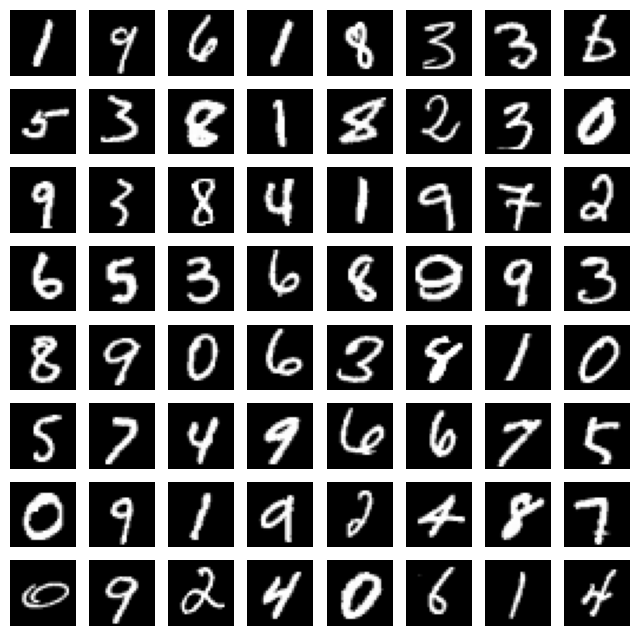

In [318]:
fig, axes = pyplot.subplots(8,8,figsize=(8,8))
for i in range(8):
    for j in range(8):
        num_index = np.random.randint(len(x_train))
        axes[i,j].imshow(x_train[num_index].reshape((28,28)), cmap="gray")
        axes[i,j].axis("off")
pyplot.show() 

Plotting data distribution between labels.

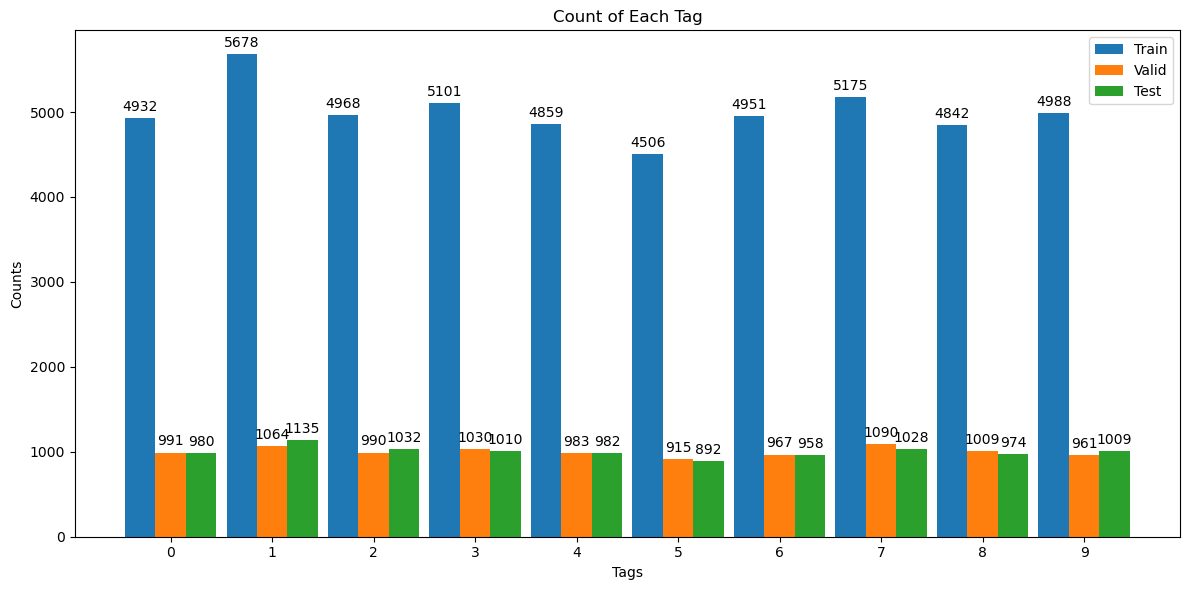

In [319]:
y_train_counts = [sum(y_train == i) for i in range(10)] # In respective order we have number of how many each label image we have, y_train - as labels
y_valid_counts = [sum(y_valid == i) for i in range(10)] # In respective order we have number of how many each label image we have, y_valid - as labels
y_test_counts =  [sum(y_test == i)  for i in range(10)] # In respective order we have number of how many each label image we have, y_test  - as labels

total = len(y_train) + len(y_valid) + len(y_test)
x = range(10)
width = 0.3

fig, ax = plt.subplots(figsize=(12, 6)) 
rects1 = ax.bar(x, y_train_counts, width, label='Train')
rects2 = ax.bar([val + width for val in x], y_valid_counts, width, label='Valid')
rects3 = ax.bar([val + width * 2 for val in x], y_test_counts, width, label='Test')

ax.set_xlabel('Tags')
ax.set_ylabel('Counts')
ax.set_title('Count of Each Tag')
ax.set_xticks([val + width for val in x])
ax.set_xticklabels(x)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
plt.tight_layout()
plt.show()

## Section 2. Classification Model Building and Definition

In [320]:
model = net2nn()
print(model)

net2nn(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)


Converting data to torch.tensors.

In [321]:
x_train, y_train, x_valid, y_valid,x_test, y_test = map(torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test))

What would the performance of the centralized model be if the data were not distributed to nodes at all? 


Parameters:

In [322]:
number_of_clients = 100
learning_rate = 0.2
numEpoch = 10
batch_size = 64
momentum = 0.8
train_amount = 5000
valid_amount = 1000
test_amount = 1000
print_amount = 4

Creating the centralized (non - distibuted model where all of the data will be sent to one model and training will be happening there)

In [323]:
centralized_model = net2nn() 

centralized_optimizer = torch.optim.SGD(centralized_model.parameters(), lr=0.01, momentum=0.9)
centralized_criterion = nn.CrossEntropyLoss() 

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

Training.

In [324]:
print("----------- Centralized ( Non - Distributed ) Model ------ \n--------------------- Training Started ------------------- ")
for epoch in range(numEpoch):
    central_train_loss, central_train_accuracy =  centralized_model.train_model (train_dl, centralized_criterion, centralized_optimizer) 
    central_test_loss,  central_test_accuracy  =  centralized_model.validate_model (test_dl,  centralized_criterion)                 
    print("Epoch: {:3.0f}".format(epoch+1) + " | Train accuracy: {:7.4f}".format(central_train_accuracy) + " | Test accuracy: {:7.4f}".format(central_test_accuracy))
print("--------------------- Training finished -------------------")

----------- Centralized ( Non - Distributed ) Model ------ 
--------------------- Training Started ------------------- 


Epoch:   1 | Train accuracy:  0.8269 | Test accuracy:  0.9270
Epoch:   2 | Train accuracy:  0.9366 | Test accuracy:  0.9464
Epoch:   3 | Train accuracy:  0.9561 | Test accuracy:  0.9617
Epoch:   4 | Train accuracy:  0.9673 | Test accuracy:  0.9663
Epoch:   5 | Train accuracy:  0.9746 | Test accuracy:  0.9710
Epoch:   6 | Train accuracy:  0.9793 | Test accuracy:  0.9707
Epoch:   7 | Train accuracy:  0.9828 | Test accuracy:  0.9743
Epoch:   8 | Train accuracy:  0.9849 | Test accuracy:  0.9764
Epoch:   9 | Train accuracy:  0.9879 | Test accuracy:  0.9747
Epoch:  10 | Train accuracy:  0.9899 | Test accuracy:  0.9770
--------------------- Training finished -------------------


## Section 3. Data distrubution to the nodes.

In [325]:
x_train_dict, y_train_dict = data_shuffler_and_distributor_for_client(x_train, y_train, "x_train", "y_train", train_amount, number_of_clients)
x_valid_dict, y_valid_dict = data_shuffler_and_distributor_for_client(x_valid, y_valid, "x_valid", "y_valid", valid_amount, number_of_clients)
x_test_dict,  y_test_dict  = data_shuffler_and_distributor_for_client(x_test,  y_test,  "x_test",  "y_test",  test_amount,  number_of_clients)

print(x_train_dict["x_train_1"].shape, y_train_dict["y_train_1"].shape)
print(x_valid_dict["x_valid_1"].shape, y_valid_dict["y_valid_1"].shape) 
print(x_test_dict ["x_test_1" ].shape, y_test_dict["y_test_1"].shape)

torch.Size([500, 784]) torch.Size([500])
torch.Size([100, 784]) torch.Size([100])
torch.Size([100, 784]) torch.Size([100])


## Section 4. Federated Averaging.

Creating the `main model` which will be our model where averaged weights will be sent in and out to individual nodes.

In [326]:
main_model = net2nn()
main_optimizer = torch.optim.SGD(main_model.parameters(), lr=learning_rate, momentum=0.9)
main_criterion = nn.CrossEntropyLoss()

Creating `individual client models` where training will happen and weights will be averaged and sent to our main model.

In [327]:
model_dict, optimizer_dict, criterion_dict = create_model_optimizer_criterion_dict(number_of_clients, learning_rate, momentum)
name_of_models = list(model_dict.keys())
name_of_optimizers=list(optimizer_dict.keys())
name_of_criterions=list(criterion_dict.keys())

Comparing intialization parameters of models and main model. 

In [328]:
print('Before updating :')
print("Main model weight : ", main_model.fc1.weight[0:1,0:5])
print("Client model weight : ", model_dict["client_1_model"].fc1.weight[0:1,0:5])

Before updating :
Main model weight :  tensor([[-0.0317, -0.0238,  0.0310, -0.0241,  0.0167]],
       grad_fn=<SliceBackward0>)
Client model weight :  tensor([[ 0.0058,  0.0087, -0.0351,  0.0189,  0.0008]],
       grad_fn=<SliceBackward0>)


Sending main model parameters to individual client models, since at the beginning while initialization all the parameters in the indivudal client models are random.

In [329]:
model_dict = send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_clients, name_of_models)

In [330]:
print('After updating :')
print("Main model weight : ", main_model.fc3.weight[0:1,0:5])
print("Client model weight : ", model_dict["client_1_model"].fc3.weight[0:1,0:5])

After updating :
Main model weight :  tensor([[ 0.0265,  0.0534, -0.0213, -0.0613,  0.0287]],
       grad_fn=<SliceBackward0>)
Client model weight :  tensor([[ 0.0265,  0.0534, -0.0213, -0.0613,  0.0287]],
       grad_fn=<SliceBackward0>)


## Section 5. Training individual models

In [331]:
start_train_end_node_process(print_amount, model_dict, name_of_criterions, name_of_optimizers, criterion_dict, name_of_models, optimizer_dict, x_train_dict, y_train_dict, x_test_dict, y_test_dict, batch_size, numEpoch)

Client:  0
epoch:   1 | train accuracy: 0.15200 | test accuracy: 0.46000
epoch:   2 | train accuracy: 0.50200 | test accuracy: 0.56000
epoch:   3 | train accuracy: 0.60400 | test accuracy: 0.71000
epoch:   4 | train accuracy: 0.80000 | test accuracy: 0.82000
epoch:   5 | train accuracy: 0.85600 | test accuracy: 0.80000
epoch:   6 | train accuracy: 0.89000 | test accuracy: 0.82000
epoch:   7 | train accuracy: 0.95400 | test accuracy: 0.85000
epoch:   8 | train accuracy: 0.94800 | test accuracy: 0.85000
epoch:   9 | train accuracy: 0.97400 | test accuracy: 0.85000
epoch:  10 | train accuracy: 0.98000 | test accuracy: 0.82000
Client:  1
epoch:   1 | train accuracy: 0.25400 | test accuracy: 0.50000
epoch:   2 | train accuracy: 0.50600 | test accuracy: 0.58000
epoch:   3 | train accuracy: 0.68800 | test accuracy: 0.66000
epoch:   4 | train accuracy: 0.77800 | test accuracy: 0.82000
epoch:   5 | train accuracy: 0.87600 | test accuracy: 0.86000
epoch:   6 | train accuracy: 0.90400 | test accu

Weights of local models are updated after training process

In [332]:
print(main_model.fc2.weight[0,0:5])
print(model_dict["client_1_model"].fc2.weight[0,0:5])

tensor([ 0.0102,  0.0121,  0.0069, -0.0009, -0.0378], grad_fn=<SliceBackward0>)
tensor([ 0.0884,  0.0427,  0.0097, -0.0138,  0.0033], grad_fn=<SliceBackward0>)


Comparing the performance of federated main model, individual local models and centralized model  

Federated main model vs individual local models before 1st iteration (on distributed test set)  
As main model is randomly initialized and no action taken on it yet, its performance is very poor at the beginning as expected.

In [333]:
before_acc_table = compare_local_and_merged_model_performance(number_of_clients, model_dict, name_of_criterions, name_of_optimizers, criterion_dict, name_of_models, optimizer_dict, main_model, main_criterion, x_test_dict, y_test_dict, batch_size)
before_test_loss, before_test_accuracy = main_model.validate_model(test_dl, main_criterion)

main_model = set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_clients, name_of_models) 

after_acc_table = compare_local_and_merged_model_performance(number_of_clients,model_dict, name_of_criterions, name_of_optimizers, criterion_dict, name_of_models, optimizer_dict, main_model,  main_criterion,  x_test_dict, y_test_dict, batch_size)
after_test_loss, after_test_accuracy = main_model.validate_model(test_dl, main_criterion)

print("Federated main model vs individual local models before FedAvg first iteration\n")
print(before_acc_table.head(), '\n\n')

print("Federated main model vs individual local models after FedAvg first iteration\n")
print(after_acc_table)

Federated main model vs individual local models before FedAvg first iteration

     Client  local_ind_model  merged_main_model
0  Client 0           0.8200             0.8200
1  Client 1           0.8100             0.8100
2  Client 2           0.7000             0.7000
3  Client 3           0.9000             0.9000
4  Client 4           0.0700             0.0700 


Federated main model vs individual local models after FedAvg first iteration

       Client  local_ind_model  merged_main_model
0    Client 0           0.8200             0.8200
1    Client 1           0.8100             0.8100
2    Client 2           0.7000             0.7000
3    Client 3           0.9000             0.9000
4    Client 4           0.0700             0.0700
..        ...              ...                ...
95  Client 95           0.1250             0.1250
96  Client 96           0.1000             0.1000
97  Client 97           0.0946             0.0946
98  Client 98           0.1346             0.1346
99

Federated main model vs centralized model before 1st iteration (on all test data)

We need to keep in mind that centralized model gets approximately %98 accuracy on all test data.

In [334]:
print("Before 1st iteration main model accuracy on all test data: {:7.4f}".format(before_test_accuracy))
print("After 1st iteration main model accuracy on all test data: {:7.4f}".format(after_test_accuracy))
print("Centralized model accuracy on all test data: {:7.4f}".format(central_test_accuracy))

Before 1st iteration main model accuracy on all test data:  0.0803
After 1st iteration main model accuracy on all test data:  0.2210
Centralized model accuracy on all test data:  0.9770


This is a single iteration, we can send the weights of the main model back to the nodes and repeat the above steps.
Now let's check how the performance of the main model improves when we repeat the iteration 10 more times.

In [335]:
for i in range(10):
    model_dict = send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_clients, name_of_models)
    start_train_end_node_process(number_of_clients, model_dict, name_of_criterions, name_of_optimizers, criterion_dict, name_of_models,optimizer_dict, x_train_dict, y_train_dict, x_test_dict, y_test_dict, batch_size, numEpoch)
    main_model = set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_clients, name_of_models) 
    test_loss, test_accuracy = main_model.validate_model(test_dl, main_criterion)
    print("Iteration", str(i+2), ": main_model accuracy on all test data: {:7.4f}".format(test_accuracy))   

Client:  0
epoch:   1 | train accuracy: 0.26800 | test accuracy: 0.50000
epoch:   2 | train accuracy: 0.55400 | test accuracy: 0.51000
epoch:   3 | train accuracy: 0.75200 | test accuracy: 0.71000
epoch:   4 | train accuracy: 0.84800 | test accuracy: 0.79000
epoch:   5 | train accuracy: 0.90800 | test accuracy: 0.83000
epoch:   6 | train accuracy: 0.93400 | test accuracy: 0.83000
epoch:   7 | train accuracy: 0.95800 | test accuracy: 0.85000
epoch:   8 | train accuracy: 0.96800 | test accuracy: 0.81000
epoch:   9 | train accuracy: 0.98800 | test accuracy: 0.85000
epoch:  10 | train accuracy: 1.00000 | test accuracy: 0.84000
Client:  1
epoch:   1 | train accuracy: 0.42200 | test accuracy: 0.49000
epoch:   2 | train accuracy: 0.58600 | test accuracy: 0.62000
epoch:   3 | train accuracy: 0.72600 | test accuracy: 0.79000
epoch:   4 | train accuracy: 0.85600 | test accuracy: 0.83000
epoch:   5 | train accuracy: 0.91000 | test accuracy: 0.85000
epoch:   6 | train accuracy: 0.92000 | test accu

The centralized model achieved an accuracy of approximately 97%. On the other hand, the main model, which was trained using the FedAvg method without directly accessing the data, started with a modest accuracy of 59%. However, through the collaborative averaging process, its performance significantly improved, reaching an impressive 91% accuracy. This result demonstrates that even when trained without directly accessing the data, the main model's performance should not be underestimated, as the FedAvg method facilitates effective knowledge aggregation and learning from distributed data sources.